# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:53 - loss: 0.6941

  29/1875 [..............................] - ETA: 3s - loss: 0.5442   

  56/1875 [..............................] - ETA: 3s - loss: 0.4682

  86/1875 [>.............................] - ETA: 3s - loss: 0.4244

 122/1875 [>.............................] - ETA: 2s - loss: 0.3923

 152/1875 [=>............................] - ETA: 2s - loss: 0.3736

 179/1875 [=>............................] - ETA: 2s - loss: 0.3603

 209/1875 [==>...........................] - ETA: 2s - loss: 0.3479

 240/1875 [==>...........................] - ETA: 2s - loss: 0.3371

 272/1875 [===>..........................] - ETA: 2s - loss: 0.3275

 303/1875 [===>..........................] - ETA: 2s - loss: 0.3194

 339/1875 [====>.........................] - ETA: 2s - loss: 0.3110

 370/1875 [====>.........................] - ETA: 2s - loss: 0.3046

 398/1875 [=====>........................] - ETA: 2s - loss: 0.2993

 430/1875 [=====>........................] - ETA: 2s - loss: 0.2938

 464/1875 [======>.......................] - ETA: 2s - loss: 0.2884

 499/1875 [======>.......................] - ETA: 2s - loss: 0.2833

 527/1875 [=======>......................] - ETA: 2s - loss: 0.2795

 561/1875 [=======>......................] - ETA: 2s - loss: 0.2752

 584/1875 [========>.....................] - ETA: 2s - loss: 0.2725

 607/1875 [========>.....................] - ETA: 2s - loss: 0.2699

 627/1875 [=========>....................] - ETA: 2s - loss: 0.2677

 651/1875 [=========>....................] - ETA: 2s - loss: 0.2652

 683/1875 [=========>....................] - ETA: 2s - loss: 0.2621

 717/1875 [==========>...................] - ETA: 1s - loss: 0.2589

 745/1875 [==========>...................] - ETA: 1s - loss: 0.2564

 772/1875 [===========>..................] - ETA: 1s - loss: 0.2541

 801/1875 [===========>..................] - ETA: 1s - loss: 0.2517

 834/1875 [============>.................] - ETA: 1s - loss: 0.2491

 865/1875 [============>.................] - ETA: 1s - loss: 0.2468

 897/1875 [=============>................] - ETA: 1s - loss: 0.2445

 927/1875 [=============>................] - ETA: 1s - loss: 0.2425

 962/1875 [==============>...............] - ETA: 1s - loss: 0.2402

 992/1875 [==============>...............] - ETA: 1s - loss: 0.2383

1023/1875 [===============>..............] - ETA: 1s - loss: 0.2364

1054/1875 [===============>..............] - ETA: 1s - loss: 0.2346

1090/1875 [================>.............] - ETA: 1s - loss: 0.2326

1126/1875 [=================>............] - ETA: 1s - loss: 0.2306

1161/1875 [=================>............] - ETA: 1s - loss: 0.2288

1193/1875 [==================>...........] - ETA: 1s - loss: 0.2272

1227/1875 [==================>...........] - ETA: 1s - loss: 0.2255

1256/1875 [===================>..........] - ETA: 1s - loss: 0.2241

1285/1875 [===================>..........] - ETA: 0s - loss: 0.2228

1316/1875 [====================>.........] - ETA: 0s - loss: 0.2214

1345/1875 [====================>.........] - ETA: 0s - loss: 0.2202

1374/1875 [====================>.........] - ETA: 0s - loss: 0.2189

1406/1875 [=====================>........] - ETA: 0s - loss: 0.2176

1432/1875 [=====================>........] - ETA: 0s - loss: 0.2166

1460/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2145

1509/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1539/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1566/1875 [========================>.....] - ETA: 0s - loss: 0.2116

1588/1875 [========================>.....] - ETA: 0s - loss: 0.2108

1615/1875 [========================>.....] - ETA: 0s - loss: 0.2099

1642/1875 [=========================>....] - ETA: 0s - loss: 0.2089

1661/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1686/1875 [=========================>....] - ETA: 0s - loss: 0.2075

1712/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1737/1875 [==========================>...] - ETA: 0s - loss: 0.2059

1767/1875 [===========================>..] - ETA: 0s - loss: 0.2049

1797/1875 [===========================>..] - ETA: 0s - loss: 0.2040

1819/1875 [============================>.] - ETA: 0s - loss: 0.2034

1842/1875 [============================>.] - ETA: 0s - loss: 0.2027

1870/1875 [============================>.] - ETA: 0s - loss: 0.2019

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2017


Epoch 2/5
   1/1875 [..............................] - ETA: 6s - loss: 0.1127

  29/1875 [..............................] - ETA: 3s - loss: 0.1116

  58/1875 [..............................] - ETA: 3s - loss: 0.1108

  88/1875 [>.............................] - ETA: 3s - loss: 0.1100

 112/1875 [>.............................] - ETA: 3s - loss: 0.1097

 137/1875 [=>............................] - ETA: 3s - loss: 0.1095

 167/1875 [=>............................] - ETA: 3s - loss: 0.1092

 196/1875 [==>...........................] - ETA: 3s - loss: 0.1090

 227/1875 [==>...........................] - ETA: 2s - loss: 0.1088

 257/1875 [===>..........................] - ETA: 2s - loss: 0.1087

 287/1875 [===>..........................] - ETA: 2s - loss: 0.1086

 314/1875 [====>.........................] - ETA: 2s - loss: 0.1085



 342/1875 [====>.........................] - ETA: 2s - loss: 0.1084

 371/1875 [====>.........................] - ETA: 2s - loss: 0.1084

 402/1875 [=====>........................] - ETA: 2s - loss: 0.1083

 428/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 452/1875 [======>.......................] - ETA: 2s - loss: 0.1081

 480/1875 [======>.......................] - ETA: 2s - loss: 0.1081

 506/1875 [=======>......................] - ETA: 2s - loss: 0.1080

 532/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 554/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 582/1875 [========>.....................] - ETA: 2s - loss: 0.1078

 607/1875 [========>.....................] - ETA: 2s - loss: 0.1078

 629/1875 [=========>....................] - ETA: 2s - loss: 0.1077

 656/1875 [=========>....................] - ETA: 2s - loss: 0.1077

 685/1875 [=========>....................] - ETA: 2s - loss: 0.1076

 711/1875 [==========>...................] - ETA: 2s - loss: 0.1076

 736/1875 [==========>...................] - ETA: 2s - loss: 0.1075

 761/1875 [===========>..................] - ETA: 2s - loss: 0.1075

 788/1875 [===========>..................] - ETA: 2s - loss: 0.1074

 811/1875 [===========>..................] - ETA: 2s - loss: 0.1074

 833/1875 [============>.................] - ETA: 1s - loss: 0.1073

 853/1875 [============>.................] - ETA: 1s - loss: 0.1073

 879/1875 [=============>................] - ETA: 1s - loss: 0.1072

 902/1875 [=============>................] - ETA: 1s - loss: 0.1072

 927/1875 [=============>................] - ETA: 1s - loss: 0.1071

 956/1875 [==============>...............] - ETA: 1s - loss: 0.1071

 980/1875 [==============>...............] - ETA: 1s - loss: 0.1070

1009/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1040/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1070/1875 [================>.............] - ETA: 1s - loss: 0.1069

1100/1875 [================>.............] - ETA: 1s - loss: 0.1068

1130/1875 [=================>............] - ETA: 1s - loss: 0.1068

1160/1875 [=================>............] - ETA: 1s - loss: 0.1067

1189/1875 [==================>...........] - ETA: 1s - loss: 0.1067

1219/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1250/1875 [===================>..........] - ETA: 1s - loss: 0.1066

1280/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1310/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1331/1875 [====================>.........] - ETA: 1s - loss: 0.1064

1353/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1380/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1409/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1437/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1466/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1494/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1524/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1554/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1583/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1612/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1641/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1670/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1700/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1730/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1759/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1787/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1814/1875 [============================>.] - ETA: 0s - loss: 0.1056

1836/1875 [============================>.] - ETA: 0s - loss: 0.1056

1864/1875 [============================>.] - ETA: 0s - loss: 0.1056

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1055


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1013

  30/1875 [..............................] - ETA: 3s - loss: 0.0992

  62/1875 [..............................] - ETA: 2s - loss: 0.0992

  92/1875 [>.............................] - ETA: 2s - loss: 0.0991

 115/1875 [>.............................] - ETA: 3s - loss: 0.0989

 143/1875 [=>............................] - ETA: 3s - loss: 0.0988

 170/1875 [=>............................] - ETA: 3s - loss: 0.0987

 190/1875 [==>...........................] - ETA: 3s - loss: 0.0987

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0987

 243/1875 [==>...........................] - ETA: 3s - loss: 0.0986

 273/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 303/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 327/1875 [====>.........................] - ETA: 2s - loss: 0.0986

 354/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 401/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 483/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 512/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 629/1875 [=========>....................] - ETA: 2s - loss: 0.0983

 658/1875 [=========>....................] - ETA: 2s - loss: 0.0983

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0983

 718/1875 [==========>...................] - ETA: 2s - loss: 0.0983

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0983

 778/1875 [===========>..................] - ETA: 2s - loss: 0.0983

 807/1875 [===========>..................] - ETA: 1s - loss: 0.0983

 837/1875 [============>.................] - ETA: 1s - loss: 0.0982

 867/1875 [============>.................] - ETA: 1s - loss: 0.0982

 897/1875 [=============>................] - ETA: 1s - loss: 0.0982

 927/1875 [=============>................] - ETA: 1s - loss: 0.0982

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 987/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1076/1875 [================>.............] - ETA: 1s - loss: 0.0981

1105/1875 [================>.............] - ETA: 1s - loss: 0.0981

1135/1875 [=================>............] - ETA: 1s - loss: 0.0981

1164/1875 [=================>............] - ETA: 1s - loss: 0.0981

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1248/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1819/1875 [============================>.] - ETA: 0s - loss: 0.0978

1847/1875 [============================>.] - ETA: 0s - loss: 0.0978



1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0886

  30/1875 [..............................] - ETA: 3s - loss: 0.0968

  58/1875 [..............................] - ETA: 3s - loss: 0.0965

  86/1875 [>.............................] - ETA: 3s - loss: 0.0963

 115/1875 [>.............................] - ETA: 3s - loss: 0.0962

 143/1875 [=>............................] - ETA: 3s - loss: 0.0961

 172/1875 [=>............................] - ETA: 3s - loss: 0.0961

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 249/1875 [==>...........................] - ETA: 3s - loss: 0.0961

 272/1875 [===>..........................] - ETA: 3s - loss: 0.0961

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 322/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 461/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 490/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 677/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 703/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 730/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 813/1875 [============>.................] - ETA: 1s - loss: 0.0962

 842/1875 [============>.................] - ETA: 1s - loss: 0.0961

 870/1875 [============>.................] - ETA: 1s - loss: 0.0961

 899/1875 [=============>................] - ETA: 1s - loss: 0.0961

 925/1875 [=============>................] - ETA: 1s - loss: 0.0961

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1073/1875 [================>.............] - ETA: 1s - loss: 0.0961

1098/1875 [================>.............] - ETA: 1s - loss: 0.0961

1119/1875 [================>.............] - ETA: 1s - loss: 0.0961

1146/1875 [=================>............] - ETA: 1s - loss: 0.0961

1174/1875 [=================>............] - ETA: 1s - loss: 0.0961

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1277/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1329/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1409/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1439/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1815/1875 [============================>.] - ETA: 0s - loss: 0.0961

1842/1875 [============================>.] - ETA: 0s - loss: 0.0961

1873/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 9s - loss: 0.0960

  29/1875 [..............................] - ETA: 3s - loss: 0.0970

  59/1875 [..............................] - ETA: 3s - loss: 0.0966

  88/1875 [>.............................] - ETA: 3s - loss: 0.0962

 118/1875 [>.............................] - ETA: 3s - loss: 0.0960

 147/1875 [=>............................] - ETA: 2s - loss: 0.0959

 177/1875 [=>............................] - ETA: 2s - loss: 0.0958

 206/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 236/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 265/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 296/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 326/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 356/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 386/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 534/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 707/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 736/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 766/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 795/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 824/1875 [============>.................] - ETA: 1s - loss: 0.0956

 853/1875 [============>.................] - ETA: 1s - loss: 0.0956

 881/1875 [=============>................] - ETA: 1s - loss: 0.0956

 910/1875 [=============>................] - ETA: 1s - loss: 0.0956

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1026/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1084/1875 [================>.............] - ETA: 1s - loss: 0.0956

1112/1875 [================>.............] - ETA: 1s - loss: 0.0956

1139/1875 [=================>............] - ETA: 1s - loss: 0.0956

1166/1875 [=================>............] - ETA: 1s - loss: 0.0956

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1296/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1363/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1448/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1587/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1827/1875 [============================>.] - ETA: 0s - loss: 0.0955

1856/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

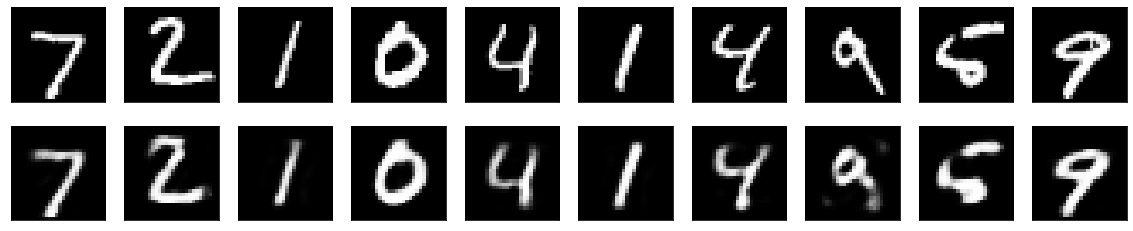

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
